In [4]:
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import json
import pprint
from sklearn.mixture import BayesianGaussianMixture

In [6]:
import seaborn as sns
sns.set(color_codes=True)

# Preprocess

### まず実験結果の読み込み

In [7]:
targetDir = "../data/output/Result1/Result/"
speedDir = "../data/output/Result1/Speed/"
brakeDir = "../data/output/Result1/Brake/"
accelDIr = "../data/output/Result1/Accel/"
steeringPositiveDir = "../data/output/Result1/SteeringPositive/"
steeringNegativeDir = "../data/output/Result1/SteeringNegative/"
manyCarDir = "../data/output/Result1/ManyCars/"
middleCarDir = "../data/output/Result1/MiddleCars/"
lessCarDir = "../data/output/Result1/LessCars/"
afternoonSunMax = "../data/output/Result1/AfternoonSunMax/"
afternoonSunMiddle = "../data/output/Result1/AfternoonSunMiddle/"
afternoonSunMin = "../data/output/Result1/AfternoonSunMin/"
cloudMax = "../data/output/Result1/CloudMax/"
cloudMiddle = "../data/output/Result1/CloudMiddle/"
cloudMin = "../data/output/Result1/CloudMin/"
sunshineMax = "../data/output/Result1/SunshineMax/"
sunshineMiddle = "../data/output/Result1/SunshineMiddle/"
sunshineMin = "../data/output/Result1/SunshineMin/"

### 読み込んだデータを元に data-frame を作成

In [101]:
df1 = pd.read_csv(speedDir + "result.csv")
df1.columns = [["id", "red", "yellow", "green", "slow"]]
df2 = pd.read_csv(brakeDir + "result.csv")
df2.columns = [["id", "brake"]]
df3 = pd.read_csv(accelDIr + "result.csv")
df3.columns = [["id", "accel"]]
df4 = pd.read_csv(steeringPositiveDir + "result.csv")
df4.columns = [["id", "steeringPositive"]]
df5 = pd.read_csv(steeringNegativeDir + "result.csv")
df5.columns = [["id", "steeringNegative"]]
df6 = pd.read_csv(afternoonSunMax + "result.csv")
df6.columns = [["id", "sunMax"]]
df7 = pd.read_csv(afternoonSunMiddle + "result.csv")
df7.columns = [["id", "sunMiddle"]]
df8 = pd.read_csv(afternoonSunMin + "result.csv")
df8.columns = [["id", "sunMin"]]
df9 = pd.read_csv(cloudMax + "result.csv")
df9.columns = [["id", "cloudMax"]]
df10 = pd.read_csv(cloudMiddle + "result.csv")
df10.columns = [["id", "cloudMiddle"]]
df11 = pd.read_csv(cloudMin + "result.csv")
df11.columns = [["id", "cloudMin"]]
df12 = pd.read_csv(sunshineMax + "result.csv")
df12.columns = [["id", "shineMax"]]
df13 = pd.read_csv(sunshineMiddle + "result.csv")
df13.columns = [["id", "shineMiddle"]]
df14 = pd.read_csv(sunshineMin + "result.csv")
df14.columns = [["id", "shineMin"]]

### Merge

In [200]:
def mergeFrames(dfs, key="id"):
    if len(dfs) == 0:
        return pd.DataFrame()
    
    acc = dfs[0]
    for df in dfs[1:]:
        acc = pd.merge(acc, df, on="id")
        
    return acc

In [201]:
df = mergeFrames([df1, df2, df3, df6, df7, df8, df9, df10, df11, df12, df13, df14])
gridSize = len(df)

### Rename

In [309]:
features =  [
    "red",  "yellow",  "green", "slow", 
    # "brake", "accel", 
    # "sunMax", "sunMiddle", "sunMin",
    # "cloudMax", "cloudMiddle", "cloudMin",
    # "shineMax", "shineMiddle", "shineMin"
]

In [367]:
normedFeatures = [
    "yellow",  "green", "slow",
    # "brake", "accel", 
    # "sunMax", "sunMiddle",
    # "cloudMax", "cloudMiddle",
    # "shineMax", "shineMiddle",
]

### 必要なデータだけ取り出す (通った経路だけ)

In [368]:
mf = df[df['red'] + df['yellow'] + df['green'] + df['slow'] > 0]
# mf = df[df['brake'] + df['accel'] > 0]
mf = mf[features]

### 確認

In [369]:
mf.describe()

,red,yellow,green,slow
count,123.000000,123.000000,123.000000,123.000000
mean,155.894309,78.211382,133.609756,11.991870
std,492.554180,116.664311,83.804675,29.764512
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,81.000000,0.000000
50%,0.000000,12.000000,119.000000,0.000000
75%,71.500000,138.500000,189.000000,3.000000
max,3831.000000,544.000000,392.000000,129.000000


In [370]:
# colors = [
#   "#FE2400",
#   "#B21D72",
#   "#5023D0",
#   "#247395",
#   "#FFFF01",
#   "#FEAF07",
#   "#247395",
# ]

In [371]:
colors = [
    "#FE2400",
    "#EC2127",
    "#D21E4E",
    "#B21D72",
    "#951E93",
    "#7421B1",
    "#5023D0",
    "#3025EA",
    "#082EFD",
    "#1147CE",
    "#247395",
    "#389D51",
    "#49C900",
    "#81D503",
    "#AFE400",
    "#DAF201",
    "#FFFF01",
    "#FEE600",
    "#FECD02",
    "#FEAF07",
    "#FF9400",
    "#FE7701",
    "#FD5800",
    "#FF3900",
]

# VBGMM

### 各特徴料を正規化する下準備

In [372]:
speeds = ["red", "yellow", "green", "slow"]
pedals = ["brake", "accel"]
steerings = ["steeringPositive", "steeringNegative"]
suns = ["sunMax", "sunMiddle", "sunMin",]
clouds = ["cloudMax", "cloudMiddle", "cloudMin",]
shines = ["shineMax", "shineMiddle", "shineMin"]

### 各特徴料を正規化

In [375]:
bf = mf.copy()
bf["sumSpeed"] = bf["red"] + bf["yellow"] + bf["green"] + bf["slow"]
# bf["sumPedal"] = bf["brake"] + bf["accel"] 
# bf["sumSteering"] = bf["steeringPositive"] + bf["steeringNegative"]
# bf["sumSuns"] = bf["sunMax"] + bf["sunMiddle"] + bf["sunMin"]
# bf["sumClouds"] = bf["cloudMax"] + bf["cloudMiddle"] + bf["cloudMin"]
# bf["sumShines"] = bf["shineMax"] + bf["shineMiddle"] + bf["shineMin"]

for key in speeds:
    bf[key] = bf[key] / bf["sumSpeed"]
    
# for key in pedals:
#     bf[key] = bf[key] / bf["sumPedal"]
    
# for key in steerings:
#     bf[key] = bf[key] / bf["sumSteering"]

# for key in suns:
#     bf[key] = bf[key] /bf["sumSuns"]
    
# for key in clouds:
#     bf[key] = bf[key] /bf["sumClouds"]
    
# for key in shines:
#     bf[key] = bf[key] /bf["sumShines"]
    
bf = bf.fillna(0)    
    
# bf = bf[features]
bf = bf[normedFeatures]

In [376]:
bf.describe()

,yellow,green,slow
count,123.000000,123.000000,123.000000
mean,0.173269,0.590656,0.080068
std,0.210690,0.339190,0.173157
min,0.000000,0.000000,0.000000
25%,0.000000,0.284895,0.000000
50%,0.058252,0.566667,0.000000
75%,0.310593,0.941462,0.019141
max,1.000000,1.000000,0.592593


### ハイパーパラメータの設定

In [377]:
components = 24
prior = 0.0001
cov_type = 'full'
cov_prior = 0.005 * np.identity(len(normedFeatures))
# cov_prior = 0.09 * np.identity(len(features))
max_iter = 200

### 一番良い seed 値をグリッドサーチする

In [378]:
def gridSearch():
    result = []
    for k in range(20):
        sd = k
        np.random.seed(sd)
        random.seed(sd)
    
        vb = BayesianGaussianMixture(
            n_components=components,
            weight_concentration_prior=prior, 
            covariance_type=cov_type,
            covariance_prior=cov_prior,
            max_iter=max_iter
        ).fit(bf)
        result.append({
                "seed": sd,
                "classes": len(set(vb.predict(bf))),
                "lower bounds": vb.lower_bound_
        })

    return sorted(result, key=lambda res: res["lower bounds"])

pprint.pprint(gridSearch())

[{'classes': 5, 'lower bounds': 1306.5180911543357, 'seed': 12},
 {'classes': 5, 'lower bounds': 1311.1286192990237, 'seed': 0},
 {'classes': 5, 'lower bounds': 1340.7655710007043, 'seed': 6},
 {'classes': 5, 'lower bounds': 1358.9672169602406, 'seed': 2},
 {'classes': 5, 'lower bounds': 1394.7797503179204, 'seed': 16},
 {'classes': 5, 'lower bounds': 1405.9172290739173, 'seed': 3},
 {'classes': 5, 'lower bounds': 1413.3851451983737, 'seed': 19},
 {'classes': 5, 'lower bounds': 1413.457656717462, 'seed': 1},
 {'classes': 4, 'lower bounds': 1421.6870063799158, 'seed': 7},
 {'classes': 5, 'lower bounds': 1450.8205623367301, 'seed': 11},
 {'classes': 5, 'lower bounds': 1467.6010049731158, 'seed': 8},
 {'classes': 3, 'lower bounds': 1483.1729328745741, 'seed': 18},
 {'classes': 5, 'lower bounds': 1490.6417061262609, 'seed': 13},
 {'classes': 4, 'lower bounds': 1495.2311117817726, 'seed': 17},
 {'classes': 5, 'lower bounds': 1505.0766266020626, 'seed': 14},
 {'classes': 3, 'lower bounds': 1

### 上で得られた一番良いシード値に設定

In [379]:
sd = 12
np.random.seed(sd)
random.seed(sd)

### 実際に Bayesian Gaussian Mixture mode でクラスタリング

In [380]:
vb = BayesianGaussianMixture(
    n_components=components,
    weight_concentration_prior=prior, 
    covariance_type=cov_type,
    covariance_prior=cov_prior,
    max_iter=max_iter    
).fit(bf)
print "class size:      ", len(set(vb.predict(bf)))
print "classes:          ", set(vb.predict(bf))
print "lower bound: ", vb.lower_bound_

class size:       5
classes:           set([9, 10, 3, 21, 5])
lower bound:  1306.51809115


### 結果の確認

In [381]:
vb.weights_

array([  8.07129119e-03,   8.00614469e-03,   7.94152403e-03,
         3.99101337e-01,   7.77130462e-03,   2.30269519e-02,
         7.56046868e-03,   7.45579309e-03,   7.35256680e-03,
         6.83257832e-02,   1.99563852e-01,   6.94341399e-03,
         6.75495663e-03,   6.57161453e-03,   6.39324886e-03,
         6.21972451e-03,   6.05091008e-03,   5.88667771e-03,
         5.72690303e-03,   5.57146503e-03,   5.42024599e-03,
         1.94283295e-01,   5.26973287e-07,   5.26920595e-11])

In [382]:
ws = ["%02f" % w for w in vb.weights_]

In [383]:
ref = pd.DataFrame(vb.means_)
# ref.columns = [features]
ref.columns = [normedFeatures]
ref["red"] = 1 - (ref["slow"] + ref["yellow"] + ref["green"])
# ref["sunMin"] = 1 - (ref["sunMax"] + ref["sunMiddle"])
# ref["cloudMin"] = 1 - (ref["cloudMax"] + ref["cloudMiddle"])
# ref["shineMin"] = 1 - (ref["shineMax"] + ref["shineMiddle"])
ref["weight"] = ws
ref.sort_values("weight", ascending=False)

,yellow,green,slow,red,weight
3,0.341225,0.287778,0.001580,0.369417,0.399101
10,0.008254,0.636591,0.349329,0.005826,0.199564
21,0.026720,0.956631,0.006315,0.010335,0.194283
9,0.171437,0.776474,0.008560,0.043529,0.068326
5,0.679147,0.201077,0.026637,0.093138,0.023027
0,0.173284,0.590623,0.080000,0.156093,0.008071
1,0.173284,0.590623,0.080001,0.156093,0.008006
2,0.173283,0.590623,0.080001,0.156092,0.007942
4,0.173283,0.590624,0.080003,0.156090,0.007771
6,0.173283,0.590625,0.080005,0.156088,0.007560


In [384]:
ref.sort_values("weight", ascending=False)[:len(set(vb.predict(bf)))]

,yellow,green,slow,red,weight
3,0.341225,0.287778,0.001580,0.369417,0.399101
10,0.008254,0.636591,0.349329,0.005826,0.199564
21,0.026720,0.956631,0.006315,0.010335,0.194283
9,0.171437,0.776474,0.008560,0.043529,0.068326
5,0.679147,0.201077,0.026637,0.093138,0.023027


# Plot histgram of each clusters

### ヒストグラムの表示と保存

In [385]:
cls = ref.sort_values("weight", ascending=False)[:len(set(vb.predict(bf)))].index

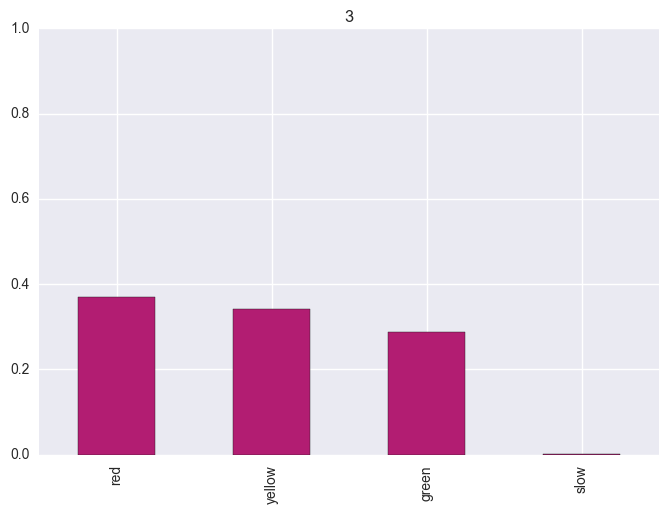

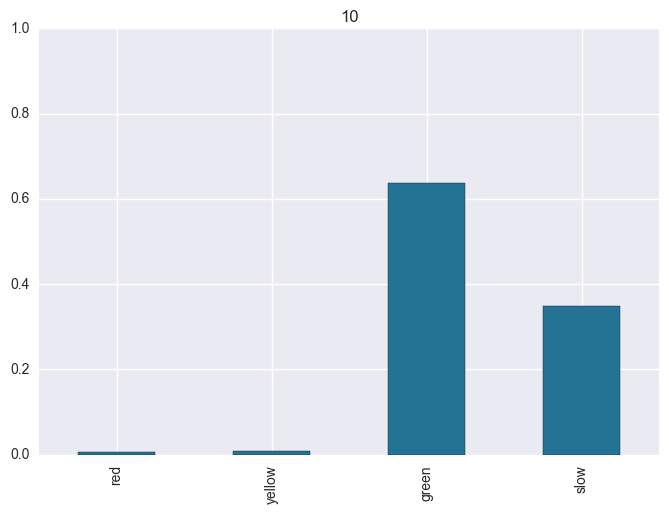

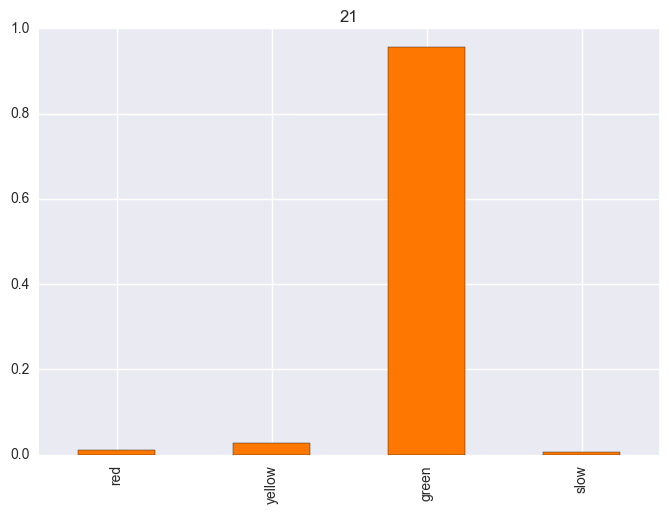

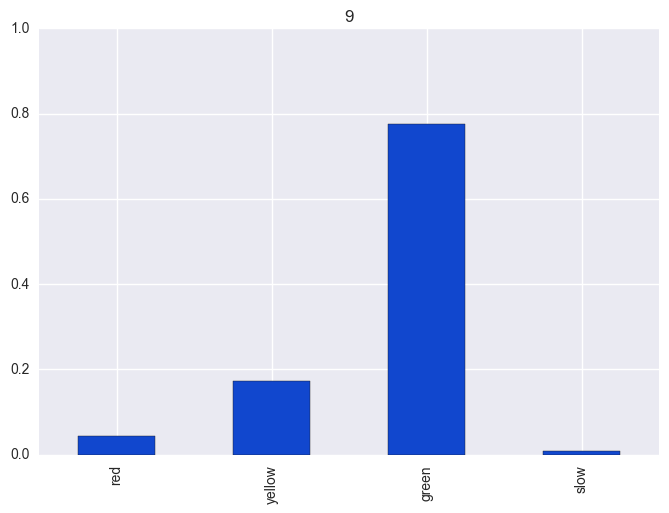

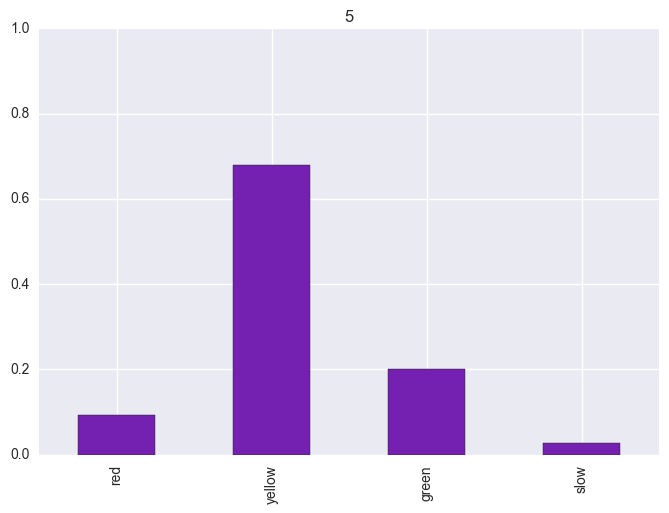

In [386]:
dir = "./img/Result1/clusters-" + str(sd)
if not os.path.exists(dir):
    os.mkdir(dir)

ref = ref[features]
for i in cls:
    ref.ix[i].plot(kind='bar', color=colors[i])
    plt.title(i)
    plt.ylim(0, 1)
    plt.savefig(dir + "/cluster" + str(i) + ".png")
    plt.show()

# Save

### 結果の保存

In [387]:
pred = zip(mf.index, vb.predict(bf))
result = np.zeros(gridSize)

for index, klass in pred:
    result[index] = klass + 1
    
np.savetxt(targetDir + "clusters.csv", result, delimiter=",", fmt="%d")

with open(dir + '/VBSetting.json', 'w') as outfile:
    data = {
        "n_components": components,
        "weight_concentration_prior": prior,
        "seed": sd
    }
    json.dump(data, outfile)

In [388]:
len(set(vb.predict(bf)))

5

In [394]:
for i, c in zip(bf.index, vb.predict(bf)):
    if c == 10:
        df.ix[i]

In [395]:
bf["cluster"] = vb.predict(bf)

In [401]:
mf[bf["cluster"] == 10].index

Int64Index([423, 424, 501, 503, 504, 530, 531, 534, 559, 560, 588, 589, 617,
            618, 646, 647, 675, 676, 704, 705, 728, 730, 731, 732, 733, 734],
           dtype='int64')

In [402]:
mf[mf.red > 0].index

Int64Index([ 48,  77, 106, 108, 169, 194, 199, 214, 215, 223, 224, 248, 249,
            250, 251, 252, 253, 275, 278, 335, 349, 350, 353, 354, 365, 366,
            383, 384, 396, 410, 425, 481, 482, 505, 506, 512, 535, 536, 542,
            543, 573, 603, 633, 634, 664, 694, 724, 725, 755, 815, 816, 846,
            876],
           dtype='int64')